## Saving , Loading Qiskit Machine Learning Models and Continuous Training

In this notebook we will show how to save and load Qiskit machine learning models. Ability to save a model is very important, 
especially when a significant ammount of time is invested in training a model on a real hardware. Also, we will show how to
resume the training of the previously saved model.

In this tutorial we will cover how to:
- Generate a sample dataset, split it into train/test dataset and plot them
- Train and save the model
- Load a saved model and resume training
- Evaluate performance of models
- PyTorch hybrid models

First off we start from the required imports. we will heavily use Scikit-Learn on the data preparation step.
In the next cell we also fix a random seed for reproducibility purposes.

In [1]:
import warnings

# Suppress warning
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA  # classical optimizer

from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import QuantumInstance, algorithm_globals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from qiskit_machine_learning.algorithms.classifiers import VQC
from IPython.display import clear_output

from time import time

seed=42
algorithm_globals.random_seed = seed  # a "seed" is a starting point for generating random numbers. 

We will be using two quantum simulators. **We will start training on the QASM simulator then will resume training on the statevector simulator.** The approach shown in this notebook can be used to train a model on a real hardware available on the cloud and then reuse the model for inference on a local simulator.

- We will train in one simulator or machine then save it and load it back then either train it more or test it in different system.
- This is how we can fine tune a pretrained model for specific task. (Use a pretrained model and use for medical purpose not need more images as it got learned some basic param on other data)

In [3]:
qi_qasm = QuantumInstance(
    Aer.get_backend("aer_simulator"),
    shots=1024,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

qi_sv = QuantumInstance(
    Aer.get_backend("aer_simulator_statevector"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

## 1. Prepare a Dataset

Now we have two simulator the next step is to prepare a dataset. Here we generate some data in the same way as other notebook. The difference is that we apply some transformations to the generated data. We generated 40 samples, each has **2** features, so our features is an array of shape **(40,2)**. Labels are obtained by summing up features by columns and if the sum is more than **1** then this sample is labeled as **1** and **0** ptherwise.

In [4]:
num_samples = 40
num_features = 2
features = 2 * algorithm_globals.random.random([num_samples, num_features]) -1
labels = 1 * (np.sum(features, axis=1) >= 0) # in [0,1]

In [5]:
print("--- Features ----")
print("features: ",features[:5])
print("features size: ",features.shape)

print("--- Labels ----")
print("labels: ",labels[:5])
print("labels size: ",labels.shape)

--- Features ----
features:  [[ 0.5479121  -0.12224312]
 [ 0.71719584  0.39473606]
 [-0.8116453   0.9512447 ]
 [ 0.5222794   0.57212861]
 [-0.74377273 -0.09922812]]
features size:  (40, 2)
--- Labels ----
labels:  [1 1 1 1 0]
labels size:  (40,)


Then we scale down our feature into a range of **[0,1]** by applying **MinMaxScaler** from scikit-learn.
Model training convergence is better when this transformation is applied.

In [6]:
features = MinMaxScaler().fit_transform(features)
features.shape

(40, 2)

In [20]:
print("--- Features After Transformation ----")
print("features: ",features[:5])
print("features size: ",features.shape)

print("--- Labels ----")
print("labels: ",labels[:5])
print("labels size: ",labels.shape)

--- Features After Transformation ----
features:  [[0.79067335 0.44566143]
 [0.88072937 0.7126244 ]
 [0.06741233 1.        ]
 [0.7770372  0.80422817]
 [0.10351936 0.45754615]]
features size:  (40, 2)
--- Labels ----
labels:  [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
labels size:  (40, 2)


We choose **VQC** or **Variational Quantum Classifier** as a model we will train. The model, by default, takes one-hot-encoded labels,
so we have to transform the labels that are in the set of **{0, 1}** into one-hot representation. We simply Scikit-Learn for this transformation 
as well. Please note that the input array must be reshaped to **(num_samples,1)** first. The **OneHotEncoder** encoder does not work 
with 1D arrays and out labels is a 1D array. In this case a user must decide either an array has only one feature(our case!) or has one sample.
Also, by default the encoder returns sparse arrays, but for the dataset plotting it is easier to have dense arrays, so we set
**sparse** to **False**.

- As we know for VQC labels should be 0 or 1 hence we have to apply One Hot encoding
- However One Hot Encoding doesn't work on 1D data so we need to reshape it

In [7]:
print(labels.shape)
print(labels[:5])

(40,)
[1 1 1 1 0]


We will first convert to 2D array then will apply One Hot Encoding

In [8]:
labels = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1,1))
print(labels.shape)
print(labels[:5])

(40, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


### 2. Split our data set into train and test

Now we split our dataset into two parts: A training dataset and a test one. As a rule of thumb **80%** of a full dataset should
go into a training part and **20%** into a test one. Our training dataset has **30** samples. The test dataset should be used
only once, when model is trained to erify how well the model behaves on unseen data. We emply **train_test_split** from scilit-learn.

In [9]:
train_features, test_features, train_labels, test_labels  = train_test_split(
    features, labels, train_size=30, random_state=algorithm_globals.random_seed
)
train_features.shape

(30, 2)

Let's plot our data and see how it looks like

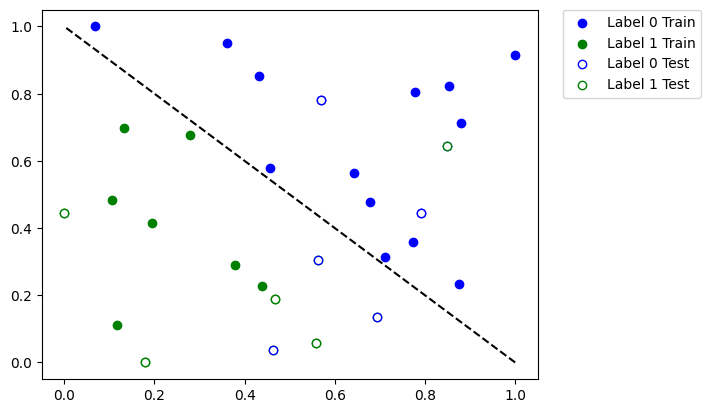

In [10]:
def plot_dataset():
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 0), 0],
        train_features[np.where(train_labels[:, 0] == 0), 1],
        marker='o',
        color="b",
        label="Label 0 Train",
    )

    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 1), 0],
        train_features[np.where(train_labels[:, 0] == 1), 1],
        marker='o',
        color='g',
        label="Label 1 Train",
    )

    plt.scatter(
        train_features[np.where(test_labels[:, 0] == 0), 0],
        train_features[np.where(test_labels[:, 0] == 0), 1],
        marker='o',
        facecolors='w',
        edgecolors="b",
        label="Label 0 Test",
    )

    plt.scatter(
        train_features[np.where(test_labels[:, 0] == 1), 0],
        train_features[np.where(test_labels[:, 0] == 1), 1],
        marker='o',
        facecolors='w',
        edgecolors='g',
        label="Label 1 Test",
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.plot([1,0],[0,1], "--", color="black")

plot_dataset()
plt.show()

On the plot above we can see:
- Solid blue dots are the samples from the training dataset labeled as **0**
- Empty blue dots are the samples from the test dataset labeled as **0**
- Solid green dots are the samples from the training dataset labeled as **1**
- Empty green dots are the samples from the test dataset labeled as **1**

We will train our model using solid dots and verify it using empty dots.

### 2. Train a model 

We will train our model in two steps. On the first step we train our model in **20** iterations.

In [11]:
maxiter = 20

Create an empty array for callback to store values of the objective function.

In [12]:
objective_values = []

We re-use a callback function from the Neural Network Classifier & Regressor to plot iteration versus objective
function value with some minor tweaks to plot objective values at each step.
 

#### The main reason of callback function is,

- The callback function is very very critical when we run the code on hardware It is the only link between python code and job. This is going to wait for the result of the job once we have result that will be loaded in the callback funtion.

- The below graph will show you how the training loss is decreasing and we are reaching towards convergence

In [13]:
# callback function that draws a live plot when the .fit method is called

def callback_graph(_, objective_value):
    clear_output(wait=True)
    objective_values.append(objective_value)
    
    plt.title("Objective Function Value Against Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Values")
    
    stage1_len = np.min((len(objective_values), maxiter))
    stage1_x = np.linspace(1, stage1_len, stage1_len)
    stage1_y = objective_values[:stage1_len]
    
    stage2_len = np.max((0, len(objective_values)- maxiter))
    stage2_x = np.linspace(maxiter, maxiter + stage2_len -1, stage2_len)
    stage2_y = objective_values[maxiter : maxiter + stage2_len]
    
    plt.plot(stage1_x, stage1_y, color="orange")
    plt.plot(stage2_x, stage2_y, color="purple")
    plt.show()
    
plt.rcParams["figure.figsize"] = (12,6)

As mentioned above we train a **VQC** model and set **COBYLA** as an optimizer with a chosen value of the **maxiter** parameter. Then we evaluate performance of the model to see how well it was trained. Then we save this model for a file. On the second step we load this model and will continue to work with it.

Here we manually construct an ansartz to fix an initial point where to start optimization from.

**RealAmplitudes** specifically indicates that the parameterized gates in the circuit are real-valued amplitudes, as opposed to complex amplitudes. Real-valued amplitudes simplify the optimization landscape, making it potentially easier to find optimal parameters.

In [14]:
original_optimizer = COBYLA(maxiter=maxiter)

ansatz = RealAmplitudes(num_features)
initial_point= np.asarray([0.5] * ansatz.num_parameters)

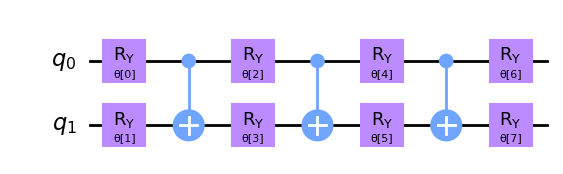

In [15]:
ansatz.decompose().draw()

#### Now it's time to train the model

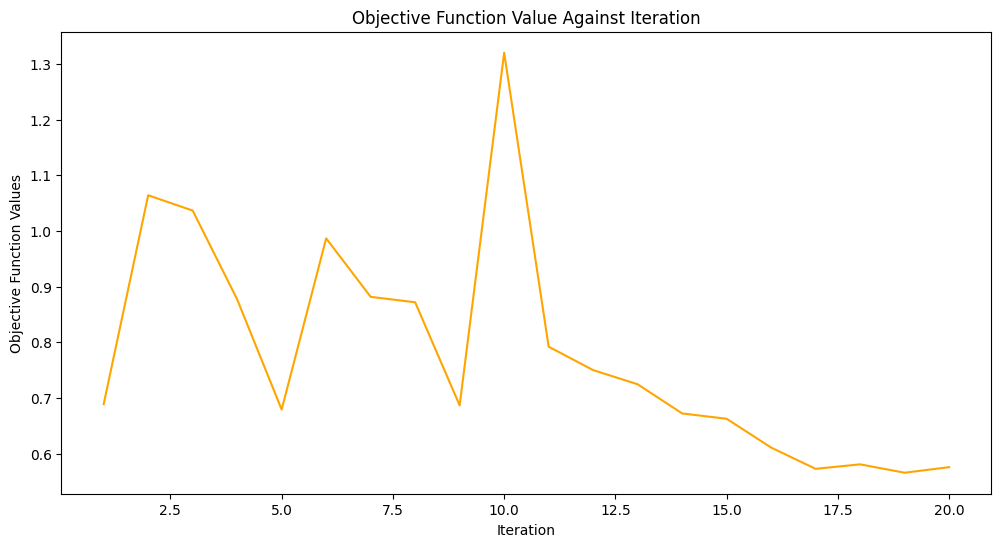

Time taken in training:  5.425505638122559


In [16]:
original_classifier =VQC(
    ansatz=ansatz, optimizer=original_optimizer, callback=callback_graph, quantum_instance=qi_qasm
)


start_time = time()
original_classifier.fit(train_features, train_labels)
end_time = time()
duration = end_time - start_time

print("Time taken in training: ",duration)

### 3. Performance of our trained model 

In [18]:
print("Train score", original_classifier.score(train_features, train_labels))
print("Test score", original_classifier.score(test_features, test_labels))

Train score 0.8
Test score 0.8


### 4. Save the model 

Next we save our model. You may choose any file name you want. Please note that the **save** method doesn't append the extension if it is not specified in the file name.

In [19]:
original_classifier.save("vqc_classifier.model")

### 5. Load a model and continue training

To load a model a user have to call a class method **load** of the corresponding model class. In our case it is **VQC**. 
We passs the same file name we used in the previous section where we save our model.

In [24]:
loaded_classifier = VQC.load("vqc_classifier.model")

Next, we want to alter the model in a way ***it can be trained further and on another simulator.***
To do so, we set **warm_start** property. When it is set to **True** and fit() is called again the model uses weights from
previous fit to start a new fit.

We also set quantum instance of the underlying network to the statevector simulator we created in the beginning of the model.
Finally, we create and set a new optimizer with **maxiter** is set to **80**, so the total number of iteration now 100 (old:20, current:80)

- **warm start** means we are **training from where we left like pretrained model** (cooking on a ovan which is already heated so that training can be faster)
- **cold strat** means we are **training from scratch**

In [28]:
loaded_classifier.warm_start =True ## Training a pretrained model
loaded_classifier.neural_network.quantum_instance = qi_sv # Will train in different system now
loaded_classifier.optimizer = COBYLA(maxiter=80) ## 80 ephocs or iteration however it will stop once find convergence

Now we continue training our model from the state we finished in the previous section

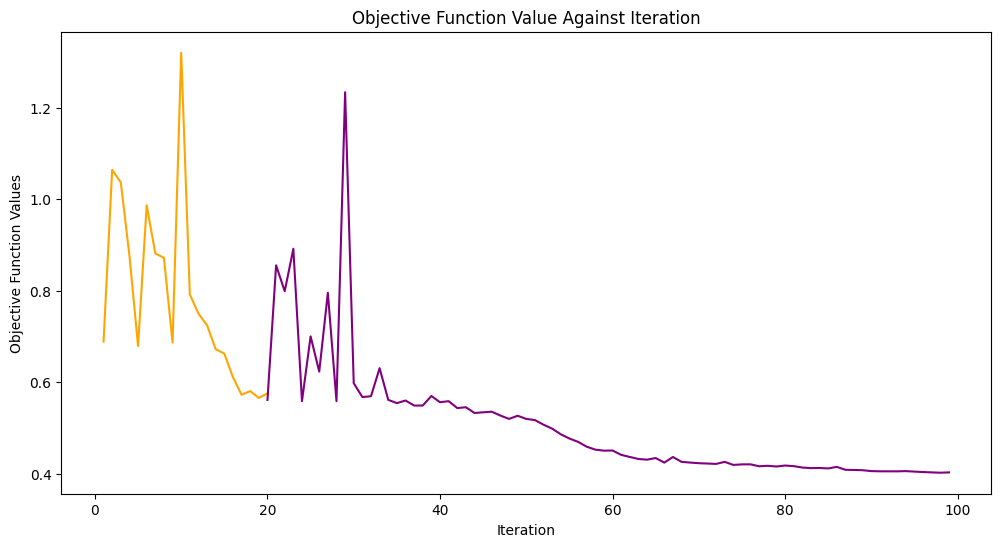

In [29]:
loaded_classifier.fit(train_features, train_labels)

Loss Fucntion now Looks great! now it has decresed more compare to previous one

Let's check the score now after training a pre trained model

#### How do we check overfitting from the loss function?
We can plot training and test loss curve. If test loss is not increasing any further but training loss is increasing further and further then it tends to overfitting we should stop training.

Also, if in both train and test data we may see high value of loss not really converged that can be a underfitting scenario.

### **Early Stopping:**  
We can stop overfitting by early stopping. Once we see train loss in between two successive iterations is less than a certain thresold and it's constant upto certain iteration say 20 epochs. Say for 15 and 20 iteration loss is not decreasing. This called **max step no best** then we should stop training. Here **max stop no best** is say 5 we waited for 5 epochs and then we stopped training no improvement in loss. Then flat line or overfitting not happen.

In [30]:
print("Train score", loaded_classifier.score(train_features, train_labels))
print("Test score", loaded_classifier.score(test_features, test_labels))

Train score 0.8666666666666667
Test score 0.8


Let's see which data points were misclassified. First we call **predict** to infer predicted values fromt he training and test features.

In [31]:
train_predicts = loaded_classifier.predict(train_features)
test_predicts = loaded_classifier.predict(test_features)

Plot the whole data set and the highlight the points that were classified in correctly

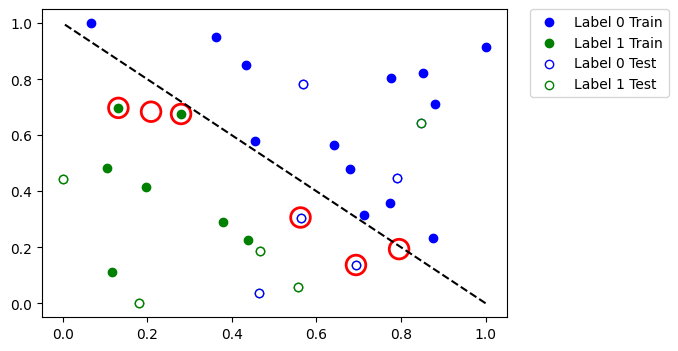

In [37]:
# return plot to default figsize
plt.rcParams["figure.figsize"] = (6,4)

plot_dataset()

# Plot missclassified data points
plt.scatter(
    train_features[np.all(train_labels != train_predicts, axis=1), 0],
    train_features[np.all(train_labels != train_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)
    
plt.scatter(
    test_features[np.all(test_labels != test_predicts, axis=1), 0],
    test_features[np.all(test_labels != test_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)


So, if you have a large dataset or a large model you can train it in multiple steps as shown in notebook

Additionally

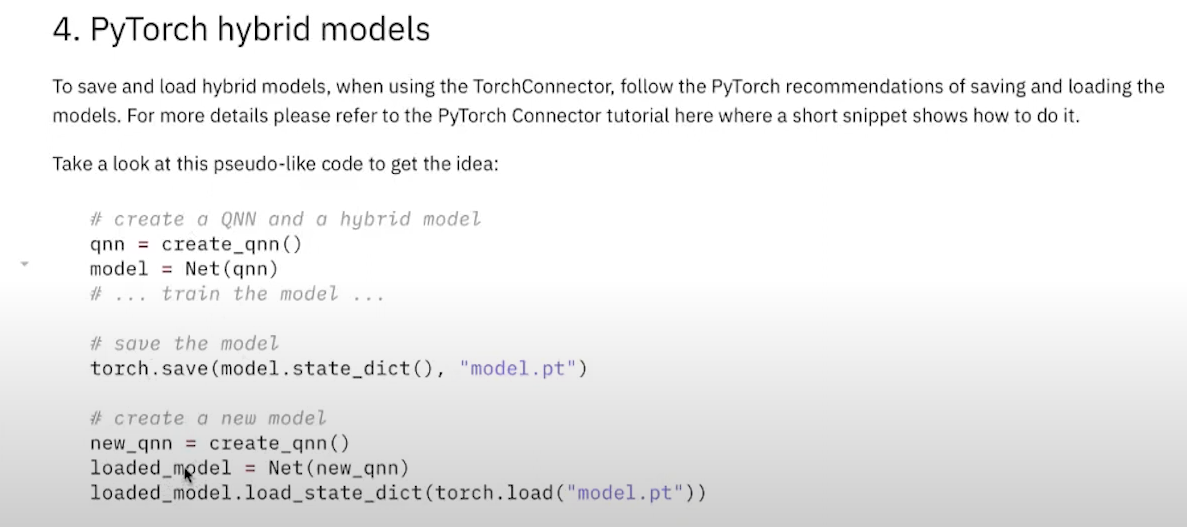